# Lung Image Classification using Convolutional Neural Networking

CNN: https://medium.com/@himadrisankarchatterjee/a-basic-introduction-to-convolutional-neural-network-8e39019b27c4
Dataset: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
Reference: 
* https://www.youtube.com/watch?v=jztwpsIzEGc
* https://github.com/nicknochnack/ImageClassification/blob/main/Getting%20Started.ipynb

1. Building a data pipeline
2. Preprocessing images for deep learning
3. Creating a deep neural network classifier
4. Evaluating model performance
5. Saving the model for deployment

## 1. Setup and Load Data

### A. Install Dependencies and Setup

In [1]:
# pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [2]:
# !pip list

In [3]:
import tensorflow as tf
import os
from matplotlib import pyplot as plt

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
# pip install opencv-python

### B. Image Ready

In [6]:
# remove dodgy images
import cv2
import imghdr

In [7]:
data_dir = 'chest_xray'

In [8]:
os.listdir(os.path.join(data_dir))

['NORMAL', 'PNEUMONIA']

In [9]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [10]:
img1 = cv2.imread(os.path.join('chest_xray', 'PNEUMONIA', 'person23_bacteria_106.jpeg'))
img1.shape

(656, 1000, 3)

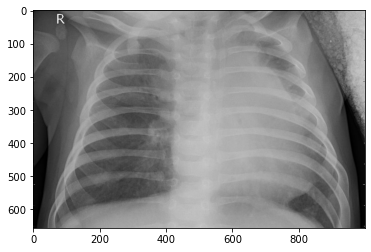

In [11]:
plt.imshow(img1)

In [12]:
for image_class in os.listdir(data_dir): # image_class: NORMAL, PNEUMONIA
    for image in os.listdir(os.path.join(data_dir, image_class)): # image: individual images in the file
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

### C. Load Data

In [110]:
import numpy as np
from matplotlib import pyplot as plt

In [111]:
data = tf.keras.utils.image_dataset_from_directory('chest_xray') # might have to revisit for seperating train, test, validation

Found 5840 files belonging to 2 classes.


In [112]:
data_iterator = data.as_numpy_iterator()

In [113]:
# get another batch from the iterator
batch = data_iterator.next()

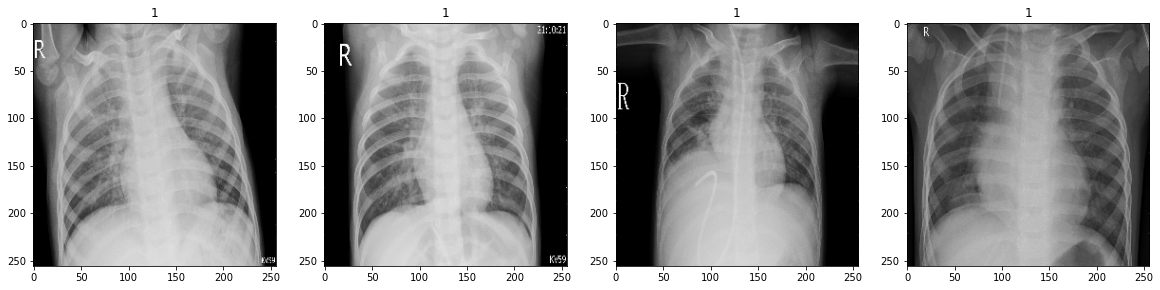

In [114]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx]) # 0: NORMAL, 1: PNEUMONIA

## 2. Preprocess Data

### A. Scale Data

In [115]:
scaled_data = data.map(lambda x,y: (x/255, y)) # it allows us to perform transformation in pipeline (tensorflow data api)

In [117]:
scaled_data.as_numpy_iterator().next()

(array([[[[0.19181967, 0.19181967, 0.19181967],
          [0.20269553, 0.20269553, 0.20269553],
          [0.24709035, 0.24709035, 0.24709035],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
 
         [[0.1827058 , 0.1827058 , 0.1827058 ],
          [0.19401366, 0.19401366, 0.19401366],
          [0.23244755, 0.23244755, 0.23244755],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
 
         [[0.16749208, 0.16749208, 0.16749208],
          [0.18495442, 0.18495442, 0.18495442],
          [0.21544303, 0.21544303, 0.21544303],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
 
         ...,
 
         [[0.        , 0.        , 0.        ],
          [0.     

### B. Split Data

In [123]:
len(scaled_data)

183

In [124]:
# train the deep learning model
train_size = int(len(scaled_data)*.7)
# evaluate the model while training
val_size = int(len(scaled_data)*.2)
# test the deep learning model after train&validation
test_size = int(len(scaled_data)*.1)+1 # add one more batch to keep the total length same

In [125]:
train = scaled_data.take(train_size)
val = scaled_data.skip(train_size).take(val_size)
test = scaled_data.skip(train_size+val_size).take(test_size)

## 3. Deep Learning Model

### A. Build Model

In [137]:
# understand the libraries that we are using
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [142]:
model = Sequential()

In [143]:
# first convolution block (16 filters, 3 by 3 pixels, stride of one, pass through a relu activation, define input shape)
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
# second convolution block
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
# third convolution block
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
# fully connected
model.add(Flatten())
# OUTPUT
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid')) # sigmoid activation function --> define NORMAL(0) & PNEUMONIA (1)

In [149]:
# using tf.optimizers.adam, binary classification
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [150]:
# show CNN steps
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 30, 30, 16)      

### B. Train Model

In [151]:
logdir='logs'

In [152]:
# save model using callbacks
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [153]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
128/128 [==============================] - 171s 1s/step - loss: 0.3437 - accuracy: 0.8604 - val_loss: 0.2597 - val_accuracy: 0.8932
Epoch 2/20
128/128 [==============================] - 195s 2s/step - loss: 0.1605 - accuracy: 0.9397 - val_loss: 0.1485 - val_accuracy: 0.9453
Epoch 3/20
128/128 [==============================] - 190s 1s/step - loss: 0.1309 - accuracy: 0.9519 - val_loss: 0.1347 - val_accuracy: 0.9540
Epoch 4/20
128/128 [==============================] - 191s 1s/step - loss: 0.1131 - accuracy: 0.9558 - val_loss: 0.1775 - val_accuracy: 0.9262
Epoch 5/20
128/128 [==============================] - 186s 1s/step - loss: 0.0998 - accuracy: 0.9653 - val_loss: 0.1389 - val_accuracy: 0.9523
Epoch 6/20
128/128 [==============================] - 187s 1s/step - loss: 0.0806 - accuracy: 0.9712 - val_loss: 0.1414 - val_accuracy: 0.9505
Epoch 7/20
128/128 [==============================] - 181s 1s/step - loss: 0.0720 - accuracy: 0.9729 - val_loss: 0.1513 - val_accuracy: 0.9497

In [155]:
hist

### C. Plot Performance

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## 4. Evaluate Performance

### A. Evaluate

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [ ]:
print(pre.result(), re.result(), acc.result())

### B. Test

In [ ]:
import cv2

#### TEST NORMAL

In [ ]:
img_normal = cv2.imread('154006829.jpg')
plt.imshow(img_normal)
plt.show()

In [ ]:
resize = tf.image.resize(img_normal, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
yhat_normal = model.predict(np.expand_dims(resize/255, 0))

In [ ]:
def predict_normal(num):
    if num > 0.5: 
        return (f'Predicted class is Sad')
    else:
        return (f'Predicted class is Happy')


In [ ]:
predict_normal(yhat_normal)

#### TEST PNEUMONIA

In [ ]:
img_pneumonia = cv2.imread('154006829.jpg')
plt.imshow(img_pneumonia)
plt.show()

In [ ]:
resize = tf.image.resize(img_pneumonia, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
yhat_pneumonia = model.predict(np.expand_dims(resize/255, 0))

In [ ]:
predict_normal(yhat_pneumonia)

## 5. Save the Model

### A. Save the Model

In [154]:
from tensorflow.keras.models import load_model

In [ ]:
model.save(os.path.join('models','imageclassifier.h5'))

In [ ]:
new_model = load_model('imageclassifier.h5')

In [ ]:
new_model.predict(np.expand_dims(resize/255, 0))